# Projeto NLP - Detectando Fake News (Noticias falsas)
Nesse projeto são apresentadas diferentes abordagens para detecção de noticias falsas.

# Motivação

No atual cenário de grande avanço tecnológico e uso das redes sociais em todas as camadas e classes sociais uma situação que causa problemas gráves é a divulgação de notícias falsas, pois essas podem prejucar a reputação de pessoas e organizações, e em casos mais gráves levar a linchamentos públicos.
Diante deste cenário, é de extrema importancia o desenvolvimento de métodos que consigam identificar possíveis noticias falsas para que seja possível tirá-las do ar.

Instalação das bibliotecas utilizadas

In [9]:
# !pip install -U scikit-learn
# !pip install pandas seaborn
# !pip install simpletransformers
# !pip install nltk

Importação das bibliotecas utilizaddas

In [11]:
import pandas as pd
import seaborn as sns
import nltk

from sklearn import metrics
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

Configuração de display da biblioteca pandas

In [12]:
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.float_format', lambda x:'%.2f' %x)

In [6]:
# Lendo os dados:

df_news = pd.read_csv('/content/sample_data/fake_or_real_news.tsv', sep='\t')
df_news.head()

,,title,text,label
0,8476,You Can Smell Hillary’s Fear,"Daniel Greenfield, a Shillman Journalism Fello...",FAKE
1,10294,Watch The Exact Moment Paul Ryan Committed Pol...,Google Pinterest Digg Linkedin Reddit Stumbleu...,FAKE
2,3608,Kerry to go to Paris in gesture of sympathy,U.S. Secretary of State John F. Kerry said Mon...,REAL
3,10142,Bernie supporters on Twitter erupt in anger ag...,"— Kaydee King (@KaydeeKing) November 9, 2016 T...",FAKE
4,875,The Battle of New York: Why This Primary Matters,It's primary day in New York and front-runners...,REAL


In [7]:
# Verificando as colunas do DataFrame:

df_news.columns

Index([' ', 'title', 'text', 'label'], dtype='object')

In [8]:
# Verificando se existem valores nulos:

df_news.isnull().sum()

         0
title    0
text     0
label    0
dtype: int64

In [9]:
# Verificando as LABELs do DataFrame:

df_news['label'].unique()

array(['FAKE', 'REAL'], dtype=object)

In [10]:
# Verificando se os ' ' e únicos para cada notícia:

df_news[' '].is_unique

True

Como a coluna ' ' são valores únicos em cada linha, iremos utilizar esses valores como índices para o nosso DataFrame.

Legendas das colunas:

- title: Título da notícia
- text: O texto da notícia
- label: Indicador se é uma notícia falsa (0) ou real (1)

In [11]:
# Transformando a coluna ' ' no índice do DataFrame:

df_news = df_news.set_index(' ')
df_news.index.names = [None]
df_news.head()

,title,text,label
8476,You Can Smell Hillary’s Fear,"Daniel Greenfield, a Shillman Journalism Fello...",FAKE
10294,Watch The Exact Moment Paul Ryan Committed Pol...,Google Pinterest Digg Linkedin Reddit Stumbleu...,FAKE
3608,Kerry to go to Paris in gesture of sympathy,U.S. Secretary of State John F. Kerry said Mon...,REAL
10142,Bernie supporters on Twitter erupt in anger ag...,"— Kaydee King (@KaydeeKing) November 9, 2016 T...",FAKE
875,The Battle of New York: Why This Primary Matters,It's primary day in New York and front-runners...,REAL


In [12]:
# Transformando a coluna categórica em números:

df_news['real'] = df_news['label'].map({'FAKE': 0, 'REAL': 1})

In [13]:
# Verificando todas as informações dos dados:

df_news.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6335 entries, 8476 to 4330
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   title   6335 non-null   object
 1   text    6335 non-null   object
 2   label   6335 non-null   object
 3   real    6335 non-null   int64 
dtypes: int64(1), object(3)
memory usage: 247.5+ KB


In [14]:
# Remover a coluna da variável categórica:

df_news = df_news.drop('label', axis=1)
df_news.head()

,title,text,real
8476,You Can Smell Hillary’s Fear,"Daniel Greenfield, a Shillman Journalism Fello...",0
10294,Watch The Exact Moment Paul Ryan Committed Pol...,Google Pinterest Digg Linkedin Reddit Stumbleu...,0
3608,Kerry to go to Paris in gesture of sympathy,U.S. Secretary of State John F. Kerry said Mon...,1
10142,Bernie supporters on Twitter erupt in anger ag...,"— Kaydee King (@KaydeeKing) November 9, 2016 T...",0
875,The Battle of New York: Why This Primary Matters,It's primary day in New York and front-runners...,1


In [15]:
# Verificando todas as informações dos dados:

df_news.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6335 entries, 8476 to 4330
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   title   6335 non-null   object
 1   text    6335 non-null   object
 2   real    6335 non-null   int64 
dtypes: int64(1), object(2)
memory usage: 198.0+ KB


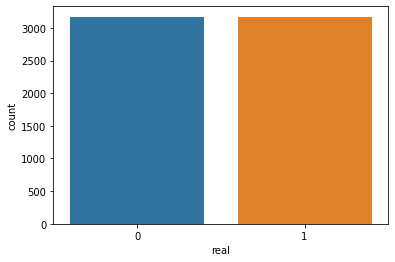

In [16]:
# Analisando graficamente a variável Target:

sns.countplot(data=df_news, x='real')

In [17]:
# Verificando a quantidades de linhas e colunas:

df_news.shape

(6335, 3)

In [18]:
# Verificando os tipos dos dados:

df_news.dtypes

title    object
text     object
real      int64
dtype: object

Vamos separar as colunas de título e texto em DataFrame distintos.

E realizar as separações da variável preditora e target em cada um dos DataFrame.

### Título da notícia

In [19]:
# Separando o título em um DataFrame:

df_news_titulo = df_news.drop('text', axis=1)
df_news_titulo.head()

,title,real
8476,You Can Smell Hillary’s Fear,0
10294,Watch The Exact Moment Paul Ryan Committed Pol...,0
3608,Kerry to go to Paris in gesture of sympathy,1
10142,Bernie supporters on Twitter erupt in anger ag...,0
875,The Battle of New York: Why This Primary Matters,1


In [20]:
# Separando as variáveis preditoras (X) da variável target (y):

X_titulo = df_news_titulo['title']
y_titulo = df_news_titulo['real']

In [21]:
# Visualizando as variáveis preditoras (X) do título:

X_titulo.head()

8476                          You Can Smell Hillary’s Fear
10294    Watch The Exact Moment Paul Ryan Committed Pol...
3608           Kerry to go to Paris in gesture of sympathy
10142    Bernie supporters on Twitter erupt in anger ag...
875       The Battle of New York: Why This Primary Matters
Name: title, dtype: object

In [22]:
# Visualizando a variável target (y) do título:

y_titulo.head()

8476     0
10294    0
3608     1
10142    0
875      1
Name: real, dtype: int64

### Texto da notícia

In [23]:
# Separando o texto em um DataFrame:

df_news_texto = df_news.drop('title', axis=1)
df_news_texto.head()

,text,real
8476,"Daniel Greenfield, a Shillman Journalism Fello...",0
10294,Google Pinterest Digg Linkedin Reddit Stumbleu...,0
3608,U.S. Secretary of State John F. Kerry said Mon...,1
10142,"— Kaydee King (@KaydeeKing) November 9, 2016 T...",0
875,It's primary day in New York and front-runners...,1


In [24]:
# Separando as variáveis preditoras (X) da variável target (y):

X_texto = df_news_texto['text']
y_texto = df_news_texto['real']

In [25]:
# Visualizando as variáveis preditoras (X) do texto:

X_texto.head()

8476     Daniel Greenfield, a Shillman Journalism Fello...
10294    Google Pinterest Digg Linkedin Reddit Stumbleu...
3608     U.S. Secretary of State John F. Kerry said Mon...
10142    — Kaydee King (@KaydeeKing) November 9, 2016 T...
875      It's primary day in New York and front-runners...
Name: text, dtype: object

In [26]:
# Visualizando a variável target (y) do texto:

y_texto.head()

8476     0
10294    0
3608     1
10142    0
875      1
Name: real, dtype: int64

# Separando as bases

Separar as bases ajuda a evitar o Data leakage.

In [27]:
# Bibliotecas utilizadas para separar as bases:

from sklearn.model_selection import train_test_split

### Título da notícia

In [28]:
# Separando as bases de teste e treino do título:

X_titulo_treino, X_titulo_teste, y_titulo_treino, y_titulo_teste = train_test_split(X_titulo, y_titulo, test_size=.2, random_state=42)

In [29]:
# Verificando quantas linhas ficou em cada base separada:

X_titulo_treino.shape, X_titulo_teste.shape, y_titulo_treino.shape, y_titulo_teste.shape

((5068,), (1267,), (5068,), (1267,))

### Texto da notícia

In [30]:
# Separando as bases de teste e treino do texto:

X_texto_treino, X_texto_teste, y_texto_treino, y_texto_teste = train_test_split(X_texto, y_texto, test_size=.2, random_state=42)

In [31]:
# Verificando quantas linhas ficarão em cada base separada:

X_texto_treino.shape, X_texto_teste.shape, y_texto_treino.shape, y_texto_teste.shape

((5068,), (1267,), (5068,), (1267,))

# Criando uma copia de segurança dos dados separados

In [32]:
# Copiando os dados para uma base, por segurança:

# Titulo
X_titulo_treino_original = X_titulo_treino.copy()
X_titulo_teste_original = X_titulo_teste.copy()

y_titulo_treino_original = y_titulo_treino.copy()
y_titulo_teste_original = y_titulo_teste.copy()

# Texto
X_texto_treino_original = X_texto_treino.copy()
X_texto_teste_original = X_texto_teste.copy()

y_texto_treino_original = y_texto_treino.copy()
y_texto_teste_original = y_texto_teste.copy()

In [33]:
# Verificando quantas linhas ficou em cada base do título de segurança:

X_titulo_treino_original.shape, X_titulo_teste_original.shape, y_titulo_treino_original.shape, y_titulo_teste_original.shape

((5068,), (1267,), (5068,), (1267,))

In [34]:
# Verificando quantas linhas ficou em cada base do texto de segurança:

X_texto_treino_original.shape, X_texto_teste_original.shape, y_texto_treino_original.shape, y_texto_teste_original.shape

((5068,), (1267,), (5068,), (1267,))

# Modelo de NLP

In [35]:
# Baixando as StopWords:

nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [36]:
# Selecionando as StopWords, em ingles:

sw_en = nltk.corpus.stopwords.words('english')

In [37]:
# Configurando o "Count Vectorizer" e "Tfid Vectorizer":

#count_vect = CountVectorizer(analyzer='word', stop_words=sw_en)
count_vect = CountVectorizer(max_df=0.95, min_df=2, stop_words=sw_en)
# vectorizer = TfidfVectorizer(analyzer='word', stop_words=sw_en)
vectorizer = TfidfVectorizer(max_df=0.95, min_df=2, stop_words=sw_en)

### Título da notícia

In [38]:
# Aplicando as Bag of Words (BoW) na base de treino do título:

X_titulo_treino_counts = count_vect.fit_transform(X_titulo_treino)
X_titulo_treino_counts.shape

(5068, 4211)

In [39]:
# Aplicando o Term Frequency-Inverse Document Frequency (Tf-idf) na base de treino do título:

X_titulo_treino_tfidf = vectorizer.fit_transform(X_titulo_treino)
X_titulo_treino_tfidf.shape

(5068, 4211)

### Texto da notícia

In [40]:
# Aplicando as Bag of Words (BoW) na base de treino do texto:

X_texto_treino_counts = count_vect.fit_transform(X_texto_treino)
X_texto_treino_counts.shape

(5068, 35864)

In [41]:
# Aplicando o Term Frequency-Inverse Document Frequency (Tf-idf) na base de treino do texto:

X_texto_treino_tfidf = vectorizer.fit_transform(X_texto_treino)
X_texto_treino_tfidf.shape

(5068, 35864)

# Modelo de Linear Support Vector Classifier

In [42]:
# Bibliotecas utilizadas para desenvolver o modelo:

from sklearn.svm import LinearSVC
from sklearn.model_selection import cross_val_score

In [43]:
# Criando o modelo:

vector_classifier = LinearSVC()

### Título da notícia

In [44]:
# Treinando o modelo utilizando o cross validation no título da notícia:

valores_f1_vc_titulo = cross_val_score(estimator=vector_classifier,
                               X=X_titulo_treino_tfidf,
                               y=y_titulo_treino.values.flatten(),
                               cv=10, # 10 splits
                               scoring='f1')
valores_f1_vc_titulo

array([0.80478088, 0.79183673, 0.81422925, 0.81017613, 0.816     ,
       0.78455285, 0.82092555, 0.79761905, 0.788     , 0.81188119])

In [45]:
# Analisando a média dos 10 splits do título da notícia:

media_f1_vc_titulo = valores_f1_vc_titulo.mean()
f'f1-score - Titulo: {media_f1_vc_titulo * 100:.2f}%'

'f1-score - Titulo: 80.40%'

### Texto da notícia

In [46]:
# Treinando o modelo utilizando o cross validation no texto da notícia:

valores_f1_vc_texto = cross_val_score(estimator=vector_classifier,
                               X=X_texto_treino_tfidf,
                               y=y_texto_treino.values.flatten(),
                               cv=10, # 10 splits
                               scoring='f1')
valores_f1_vc_texto

array([0.93117409, 0.932     , 0.91313131, 0.9500998 , 0.93522267,
       0.93522267, 0.96222664, 0.9372549 , 0.92555332, 0.93787575])

In [47]:
# Analisando a média dos 10 splits do texto da notícia:

media_f1_vc_texto = valores_f1_vc_texto.mean()
f'f1-score - Texto: {media_f1_vc_texto * 100:.2f}%'

'f1-score - Texto: 93.60%'

# Feature escolhida

Foi realizado o Cross validation e o modelo de "Vector Classifier" se saiu melhor utilizando o texto da notícia, com isso foi escolhido realizar usando o texto e não o título.

# Final

Nesse momento já decidimos em qual vamos aplicar a classificação, com isso podemos realizar inferências dos valores na base de teste.

### Texto da notícia

In [48]:
# Realizando o fit na base de treino do texto da notícia:

vector_classifier.fit(X_texto_treino_tfidf, y_texto_treino.values.flatten())

LinearSVC()

In [49]:
# Visualizando o coeficiente obtido:

vector_classifier.coef_

array([[-0.27833467, -0.08987941,  0.00994216, ..., -0.06644512,
        -0.01784778, -0.01393999]])

In [50]:
# Aplicando o Term Frequency-Inverse Document Frequency (Tf-idf) na base de teste:

X_texto_teste_tfidf = vectorizer.transform(X_texto_teste)
X_texto_teste_tfidf.shape

(1267, 35864)

In [51]:
# Realizando a predição na base de teste:

predicoes_real = vector_classifier.predict(X_texto_teste_tfidf)
predicoes_real[:5]

array([0, 0, 0, 0, 0])

In [52]:
# Visualisando as métricas do predict do teste:

print(metrics.classification_report(y_texto_teste, predicoes_real))
print(metrics.confusion_matrix(y_texto_teste, predicoes_real))

              precision    recall  f1-score   support

           0       0.93      0.95      0.94       628
           1       0.95      0.93      0.94       639

    accuracy                           0.94      1267
   macro avg       0.94      0.94      0.94      1267
weighted avg       0.94      0.94      0.94      1267

[[595  33]
 [ 44 595]]


O modelo teve uma ótima performance, pois acertou 94% das noticias reais existente. 

Se o modelo "chutasse" todos as notícias reais, teria uma chance de acerto no total de 50%. Com isso podemos dizer que nosso modelo foi muito bem dentro desse cenário.

# Modelo de Simpletransformers

### Texto da notícia

In [60]:
# Bibliotecas utilizadas:
  
from simpletransformers.classification import (ClassificationModel, ClassificationArgs)

In [61]:
# Criando DataFrame com as variáveis preditoras e target da base de treino e teste:

df_texto_treino = pd.concat([X_texto_treino, y_texto_treino], axis=1)
df_texto_teste = pd.concat([X_texto_teste, y_texto_teste], axis=1)

In [62]:
# Visualizando os dados do novo DataFrame:

df_texto_treino.head(5)

,text,real
2527,Donald Trump received a key endorsement for hi...,1
9812,"Nina November 6, 2016 @ 2:39 pm \nPolish gover...",0
5873,Time: Investigating Hillary is an Attack on Al...,0
10529,"Taki's Magazine October 28, 2016 \nThis electi...",0
5866,Pakistan Pakistan's cricketer turned politicia...,0


In [56]:
# Visualizando os dados do novo DataFrame:

df_texto_teste.head()

,text,real
9957,Will Trump pull a Brexit times ten? What would...,0
7596,Clintons Are Under Multiple FBI Investigations...,0
8905,Dispatches from Eric Zuesse This piece is cros...,0
8752,Print \n[Ed. – Every now and then the facade c...,0
7804,Nanny In Jail After Force Feeding Baby To Deat...,0


In [63]:
# Criando a variavel dos argumentos:

treino_args = ClassificationArgs(num_train_epochs=8)

In [64]:
# Criando o modelo, utilizando o modelo "roberta":

transforme = ClassificationModel('roberta','roberta-base', args=treino_args, use_cuda=True)

Some weights of the model checkpoint at roberta-base were not used when initializing RobertaForSequenceClassification: ['lm_head.layer_norm.bias', 'lm_head.dense.weight', 'lm_head.bias', 'roberta.pooler.dense.weight', 'roberta.pooler.dense.bias', 'lm_head.layer_norm.weight', 'lm_head.decoder.weight', 'lm_head.dense.bias']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.out_proj.bias', 'classifi

Downloading:   0%|          | 0.00/1.29M [00:00<?, ?B/s]

In [65]:
# Treinando o modelo na base de treino:

transforme.train_model(df_texto_treino[['text','real']])

/usr/local/lib/python3.7/dist-packages/simpletransformers/classification/classification_model.py:602: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  "Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels."


  0%|          | 0/5068 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:310: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,


Epoch:   0%|          | 0/8 [00:00<?, ?it/s]

Running Epoch 0 of 8:   0%|          | 0/634 [00:00<?, ?it/s]

Running Epoch 1 of 8:   0%|          | 0/634 [00:00<?, ?it/s]

Running Epoch 2 of 8:   0%|          | 0/634 [00:00<?, ?it/s]

Running Epoch 3 of 8:   0%|          | 0/634 [00:00<?, ?it/s]

Running Epoch 4 of 8:   0%|          | 0/634 [00:00<?, ?it/s]

Running Epoch 5 of 8:   0%|          | 0/634 [00:00<?, ?it/s]

Running Epoch 6 of 8:   0%|          | 0/634 [00:00<?, ?it/s]

Running Epoch 7 of 8:   0%|          | 0/634 [00:00<?, ?it/s]

(5072, 0.03493102834404267)

In [66]:
# Realizando as predições na base de teste:

predicoes, _ = transforme.predict(df_texto_teste['text'].tolist())

  0%|          | 0/1267 [00:00<?, ?it/s]

  0%|          | 0/159 [00:00<?, ?it/s]

In [67]:
# Visualisando as métricas do predict do teste:

print(metrics.classification_report(df_texto_teste['real'], predicoes))
print(metrics.confusion_matrix(df_texto_teste['real'], predicoes))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       628
           1       1.00      1.00      1.00       639

    accuracy                           1.00      1267
   macro avg       1.00      1.00      1.00      1267
weighted avg       1.00      1.00      1.00      1267

[[625   3]
 [  0 639]]


Aplicando o modelo de "Simpletransformers" na base de dados tivemos uma performance muito boa, conseguindo acerta 100% das Fake news e errando somente 3 notícias reais.

Com isso podemos dizer que o modelo utilizando "Simpletransformers" terá melhor performance, comparando com o Term Frequency-Inverse Document Frequency (Tf-idf) e Bag of Words (BoW).